<a href="https://colab.research.google.com/github/mkcyoung/deep-green-space/blob/main/deeplab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deeplabv3 w/ cityscapes dataset

In an effort to create an automated way to calculate the green value index (GVI) for google street view (gsv) images in salt lake city (slc), I train deeplabv3 on the cityscapes dataset to recognize vegetation (trees, bushes) and terrain (grass). 

After observing that simply training on the cityscape data led to lackluster predictions on gsv images, I hand labeled 150 train and 60 test images from the slc gsv data and retrainged the model.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as Func
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import time
from datetime import datetime

import torchvision
import torchvision.transforms.functional as F
import random 
import numbers
import copy


from PIL import Image
from skimage import io
from skimage import color

import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.pyplot import imshow
from matplotlib.colors import ListedColormap
%matplotlib inline

# from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler
import cv2
import os
from tqdm.notebook import tqdm
# Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`

import torchvision.models as models
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
# from torchvision.models.segmentation import deeplabv3_resnet101
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision import transforms

# Cityscapes dataset
# from torchvision.datasets import Cityscapes
# ! cd /content/drive/"My Drive"/"Colab Notebooks"/"Deep Learning 2020"/project
!cp "drive/My Drive/Colab Notebooks/Deep Learning 2020/project/Cityscapes.py" .
from Cityscapes import Cityscapes

import torch.optim as optim
from google.colab import files
from torch.optim.lr_scheduler import LambdaLR
import glob
import matplotlib.gridspec as gridspec

# cityscape scripts for data prep
# !pip install cityscapesscripts
# !pip install cityscapesscripts[gui]
# !pip install /content/drive/"My Drive"/"Colab Notebooks"/"Deep Learning 2020"/project/cityscapesScripts

# https://github.com/pytorch/pytorch/issues/40403
# torch.multiprocessing.set_start_method('spawn') # good solution !!!!

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# Training on cityscape data

## Prepping the dataset

Creating datasets w/ transforms.

In [ ]:
root = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/cityscapes'

# im_size = 768
im_size = 1024

# I'm gonna put a hold on resizing, I think it's problematic, just taking smaller crop
# resized = 740 # Let's try 740 
#resized = 400 400 seemed too small, didn't work very well at all

# Training transforms
train_transforms = transforms.Compose([
    transforms.RandomCrop(size=(im_size,im_size)), # This is essentially doing my resizing here
    # transforms.Resize(size=(resized,resized),interpolation=Image.NEAREST), # Resize after my random crop 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for pretrained models
])

#target transforms
target_transforms = transforms.Compose([
    transforms.RandomCrop(size=(im_size,im_size)), # This is essentially doing my resizing here
    # transforms.Resize(size=(resized,resized),interpolation=Image.NEAREST),
    transforms.RandomHorizontalFlip()
])

# Validation transforms
val_transforms = transforms.Compose([
    transforms.RandomCrop(size=(im_size,im_size)),
    # transforms.Resize(size=(resized,resized),interpolation=Image.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # needed for pretrained models
])

#val target transforms
val_target_transforms = transforms.Compose([
    transforms.RandomCrop(size=(im_size,im_size)), # This is essentially doing my resizing here
    # transforms.Resize(size=(resized,resized),interpolation=Image.NEAREST),
])


# create datasets
# Use target_type = 'semantic_tress' to get the tree labels, semantic = tree + terrain
# training data
train_data = Cityscapes(root, split='train', mode='fine',
                     target_type='semantic', transform=train_transforms, target_transform=target_transforms)

# May need to transform the validation target to be in same form as the training targets... i.e. tensors?
# validation data
val_data = Cityscapes(root, split='val', mode='fine',
                     target_type='semantic', transform=val_transforms, target_transform=val_target_transforms)

print("Train length: ",len(train_data),"Val length: ",len(val_data))

Train length:  2975 Val length:  500


Datasets with different crops (used for visualizaing model predictions)

In [ ]:
root = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/cityscapes'
im_h = 1024
im_w = 2048


# Training transforms
train_transforms = transforms.Compose([
    # transforms.Resize(512),
    transforms.RandomCrop(size=(im_h,im_w)), # This is essentially doing my resizing here
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for pretrained models
])

#target transforms
target_transforms = transforms.Compose([
    # transforms.Resize(512),
    transforms.RandomCrop(size=(im_h,im_w)), # This is essentially doing my resizing here
    transforms.RandomHorizontalFlip()
])

# Validation transforms
val_transforms = transforms.Compose([
    # transforms.Resize(512),
    transforms.RandomCrop(size=(im_h,im_w)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # needed for pretrained models
])

#val target transforms
val_target_transforms = transforms.Compose([
    # transforms.Resize(512),
    transforms.RandomCrop(size=(im_h,im_w)), # This is essentially doing my resizing here
])


# create datasets
# training data
train_data_full = Cityscapes(root, split='train', mode='fine',
                     target_type='semantic', transform=train_transforms, target_transform=target_transforms)

# May need to transform the validation target to be in same form as the training targets... i.e. tensors?
# validation data
val_data_full = Cityscapes(root, split='val', mode='fine',
                     target_type='semantic', transform=val_transforms, target_transform=val_target_transforms)

print("Train length: ",len(train_data_full),"Val length: ",len(val_data_full))

Train length:  2975 Val length:  500


Creating dataloaders (uses datasets with crops)

In [ ]:
# Create data loaders
batch_size = 3

# sample_train = list(range(0, len(train_data), 1000))
# sample_val = list(range(0, len(val_data), 100))

# sampled_train = torch.utils.data.Subset(train_data, sample_train)
# sampled_val = torch.utils.data.Subset(val_data, sample_val)

# # Sample of data
# train_loader = DataLoader(
#   sampled_train, batch_size=batch_size, shuffle=True, drop_last=True) #, num_workers=2)

# val_loader = DataLoader(
#     sampled_val, batch_size=batch_size, shuffle=False) #, num_workers=2)

# Full dataset
train_loader = DataLoader(
  train_data, batch_size=batch_size, shuffle=True, drop_last=True) #, num_workers=2)

val_loader = DataLoader(
    val_data, batch_size=batch_size, shuffle=False, drop_last=True) #, num_workers=2)

## Prepping the model architecture

In [ ]:
num_classes = 2 # Number of classes I'm outputting (1) vegetation, and (0) everything else, although may 
# need to change to accomodate 255 (ignore during training) and -1 (license plate) - no, just set ignore index in criterion (loss function) 

# Looks like if I set pretrained to False then I can change the number of classes
# model = models.segmentation.deeplabv3_resnet101(pretrained=False, progress=True, num_classes=num_classes, aux_loss=True)
# model.train()

# If I want to keep pretrained weights, then I need to just change classifier part of the network
# Modifying output of DeepLab

# https://stackoverflow.com/questions/63892031/how-to-train-deeplabv3-on-custom-dataset-on-pytorch

def custom_DeepLabv3(out_channel):
  # model = deeplabv3_resnet101(pretrained=True, progress=True) # will give 101 a try
  model = deeplabv3_resnet50(pretrained=True, progress=True)
  model.classifier = DeepLabHead(2048, out_channel)
  # adjust aux layer as well
  model.aux_classifier[4] = nn.Conv2d(256, out_channel,kernel_size=(1,1),stride=(1,1))

  #Set the model in training mode
  model.to(device)
  model.train()
  return model


model = custom_DeepLabv3(num_classes)

# # Potentially a different way
# # https://discuss.pytorch.org/t/removing-classification-layer-for-resnet101-deeplabv3/51004
# model = models.segmentation.deeplabv3_resnet101()
# # nb_classes = 1 #number of classes I want to output
# model.classifier[4] = nn.Conv2d(
#     in_channels=256,
#     out_channels=nb_classes,
#     kernel_size=1,
#     stride=1
# )

# print(model)

### Functions for visualizing images and labels

In [ ]:
def show_examples(img,target,label):

    # I want to denormalize the image so it looks better
    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(img)

    img_ = img.cpu().numpy()
    target_ = target.cpu().numpy()
    smnt_ = label.cpu().numpy()

    # I want to create a color map for my different classes
    # https://stackoverflow.com/questions/52284019/map-a-specific-string-value-to-a-specific-color-in-matplotlib-pyplot-imshow
    colors = [ "#f15bb5", "#02c39a"]  
    cmap = ListedColormap(colors)   

    #convert image back to Height,Width,Channels
    img_ = np.transpose(img_, (1,2,0))
    smnt_[smnt_ == 1] = 100
    target_[target_ == 1] = 100
    smnt_[smnt_ == 255] = 0
    target_[target_ == 255] = 0

    
    # Displaying images and targets side by side
    fig, axarr = plt.subplots(1, 3,figsize=(15,4))
    fig.suptitle('cityscape example + targets + labels')
    axarr[0].imshow(img_,aspect='auto')
    axarr[0].set_title("raw image")
    axarr[1].imshow(target_,vmin=0, vmax=len(cmap.colors), cmap=cmap,aspect='auto')
    axarr[1].set_title("semantic target")
    axarr[2].imshow(smnt_,vmin=0, vmax=len(cmap.colors), cmap=cmap,aspect='auto')
    axarr[2].set_title("model output")
    

## Params + Optimizer + loss function

In [ ]:
# Need to decide which parameteres I want to update.
# Two modes: fineting mode, where I only adjust the weights of the classifier,
# and full training mode, where I adjust all weights.
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
# Can fine tune later one using above linl
params_to_update = model.parameters()


# Define my loss function
# I may need to do address the -1 class somehow....
# I think it's a license plate? 
# May need to remap the dataset again and assign EVERYTHING to either 0 or 1
# Feels more intuitive?
criterion = nn.CrossEntropyLoss(ignore_index=255, reduction='mean')


# Optimizer
optimizer = optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999))
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)


## Validation + Loss function

Create a validation method that takes as input examples and outputs the loss, the accuracy and any other necessary metrics.

In [ ]:
# Validation helper

def validate_phase(val_dl,best_acc,best_wts):
    # Put the model in eval mode
    model.eval()
    losses = []
    accuracies = []
    ious = []
    epoch_start = time.time()
    # Think this helps....
    with torch.no_grad():
      for i, batch in enumerate(tqdm(val_dl)):
          inputs = batch[0]
          labels = batch[1]
          inputs, labels = inputs.to(device), labels.to(device)
          # print("inputs shape:",inputs.shape)
          # print("labels shape:",labels.shape)
          # print("unique labels: ",np.unique(labels.cpu().numpy()))
          # print("labels",labels)

          outputs = model(inputs)           # 2. Run the model
          output = outputs['out']
          aux = outputs['aux']
          # print("output shape:",output.shape)
          # print("aux shape:",aux.shape)
          # print("output:",output)

          # Need to refactor the output to return argmax for each pixel
          preds = output.max(dim=1)[1].type(torch.LongTensor).to(device)
          # print("preds shape: ",preds.shape)
          # print("predictions:",preds)
          

          # I think outputs and labels need to be the same shape obviously,
          # but outputs need to have an extram dim:
          # https://discuss.pytorch.org/t/valueerror-expected-target-size-32-7-got-torch-size-32/42409/4

          loss = criterion(output, labels) # 3. Calculate loss
          losses.append(loss.item())

          # May be helpful for other loss: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
          # outputs, aux_outputs = model(inputs)
          # loss1 = criterion(outputs, labels)
          # loss2 = criterion(aux_outputs, labels)
          # loss = loss1 + 0.4*loss2
          
          # Convert target and predictions to numpy
          labels_np = labels.cpu().numpy()
          preds_np = preds.cpu().numpy()

          # 4. Calculate pixel accuracy: https://github.com/CSAILVision/semantic-segmentation-pytorch/blob/master/mit_semseg/utils.py
          # This needs to be by batch
          valid = (labels_np != 255)
          acc_sum = (valid * (preds_np == labels_np)).sum(1).sum(1)
          valid_sum = valid.sum(1).sum(1)
          acc = acc_sum / valid_sum
          accuracies.append(np.mean(acc))

          # 5. calculate IoU metric: https://www.jeremyjordan.me/evaluating-image-segmentation-models/
          intersection = np.logical_and(labels_np, preds_np)
          # print(intersection.shape)
          union = np.logical_or(labels_np, preds_np)
          # print(union.shape)
          iou_score = intersection.sum(1).sum(1) / (union.sum(1).sum(1) + 0.00001)
          iou_score = np.mean(iou_score)
          # iou_score = np.sum(intersection) / np.sum(union)
          ious.append(iou_score)

          # print('[VAL] Loss: {:.4f} Acc: {:.4f}'.format(loss.item(), np.mean(acc)))
          # if i == 0:
          #   show_examples(inputs[0],labels[0],preds[0].squeeze())
          #   break
          
      
      # epoch_loss = np.sqrt(sum(losses) / len(losses))
      epoch_loss = np.mean(losses)
      epoch_acc = np.mean(accuracies)
      epoch_iou = np.mean(ious)
      epoch_time = time.time() - epoch_start
      # deep copy the model
      if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_wts = copy.deepcopy(model.state_dict())
          # save
          MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-val-epoch-{}-{}.pth'.format(epoch+1,datetime.now().time())
          torch.save(model.state_dict(), MODEL_PATH)

      print("[VAL] Epoch: {} Loss: {} Pixel Acc: {} IoU: {} Time: {:.0f}:{:.0f}".format(epoch+1, epoch_loss,
                                                                  epoch_acc,
                                                                  epoch_iou,
                                                                  epoch_time // 60, 
                                                                  epoch_time % 60))                                                                
    return epoch_loss, epoch_acc, epoch_iou, best_acc, best_wts

# epoch = 0
# best_acc = 0.9
# best_wts = None
# loss, acc, iou, best_acc, best_wts = validate_phase(val_loader,best_acc,best_wts)
# print(loss,acc,iou,best_acc,best_wts)

## Training helper

First train by using transfer learning (i.e. keeping pretrained weights from COCO): https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [ ]:
def train_phase(train_dl):
    model.train()
    losses = []
    accuracies = []
    ious = []
    epoch_start = time.time()
    with torch.enable_grad(): # resets grads
      for i, batch in enumerate(tqdm(train_dl)):
          inputs = batch[0]
          labels = batch[1]
          inputs, labels = inputs.to(device), labels.type(torch.LongTensor).to(device)

          optimizer.zero_grad()             # 1. Zero the parameter gradients
          outputs = model(inputs)           # 2. Run the model
          output = outputs['out']
          aux = outputs['aux']          

          loss = criterion(output, labels) # 3. Calculate loss
          losses.append(loss.item())
          

          loss.backward()                   # 4. Backward propagate the loss
          optimizer.step()                  # 5. Optimize the network

          # Need to refactor the output to return argmax for each pixel
          preds = output.max(dim=1)[1].type(torch.LongTensor).to(device)

          # Convert target and predictions to numpy
          labels_np = labels.cpu().numpy()
          preds_np = preds.cpu().numpy()
          
          # 4. Calculate pixel accuracy: https://github.com/CSAILVision/semantic-segmentation-pytorch/blob/master/mit_semseg/utils.py
          # This needs to be by batch
          valid = (labels_np != 255)
          acc_sum = (valid * (preds_np == labels_np)).sum(1).sum(1)
          valid_sum = valid.sum(1).sum(1)
          acc = acc_sum / valid_sum
          accuracies.append(np.mean(acc))

          # 5. calculate IoU metric: https://www.jeremyjordan.me/evaluating-image-segmentation-models/
          intersection = np.logical_and(labels_np, preds_np)
          # print(intersection.shape)
          union = np.logical_or(labels_np, preds_np)
          # print(union.shape)
          iou_score = intersection.sum(1).sum(1) / (union.sum(1).sum(1) + 0.00001)
          iou_score = np.mean(iou_score)
          # iou_score = np.sum(intersection) / np.sum(union)
          ious.append(iou_score)

          # print('[TRN] Loss: {:.4f} Acc: {:.4f}'.format(loss.item(), np.mean(acc)))
          # if i == 0:
          #   break

    # save
    # MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-trn-epoch-{}-{}.pth'.format(epoch+1,datetime.now().time())
    MODEL_PATH_WHOLE = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-whole-epoch-{}-{}.tar'.format(epoch+1,datetime.now().time())
    # torch.save(model.state_dict(), MODEL_PATH)
    torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, MODEL_PATH_WHOLE)

    epoch_loss = np.mean(losses)
    epoch_acc = np.mean(accuracies)
    epoch_iou = np.mean(ious)
    epoch_time = time.time() - epoch_start
    print("[TRN] Epoch: {} Loss: {} Pixel Acc: {} IoU: {} Time: {:.0f}:{:.0f}".format(epoch+1,
                                                                epoch_loss, 
                                                                epoch_acc,
                                                                epoch_iou,   
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss, epoch_acc, epoch_iou

# epoch = 0
# loss, acc, iou = train_phase(train_loader)
# print(loss,acc,iou)

## Main training + Val loop

In [ ]:
# Load Entire model state

# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/nature_models/round 2/model-whole-epoch-4-01:00:53.027089.tar'
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-whole-epoch-4-01:37:46.052522.tar'
PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/tree_grass_1024/best_tree_grass.tar'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']


In [ ]:
# Load a previous checkpoint to resume training if necessary
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/round 2/model-trn-epoch-2-11:03:59.766161.pth'
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/tree_models/round 3/best_model_tree.pth'
# model.load_state_dict(torch.load(PATH))

# Init best model weights and accuracy
# best_wts = copy.deepcopy(model.state_dict())
best_wts = None
best_acc = 0
epochs = 10

train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

for epoch in range(epochs):
    # Train and val
    train_loss, train_acc, train_iou = train_phase(train_loader)
    val_loss, val_acc, val_iou, best_acc, best_wts = validate_phase(val_loader,best_acc,best_wts)

    # Adjust learning rate if needs be
    scheduler.step(val_loss)

    # store train values    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_ious.append(train_iou)

    # store val values
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)



# load best model weights
# best_model = model.load_state_dict(best_wts)
# save whole model: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/models/model_nature_400.pth'
# torch.save(best_wts, MODEL_PATH)

## Plot loss and acc

Because I had to restart training multiple times, I have to reassemble the losses and accuracies. Additionally, I calculated my IoU's incorrectly (by not removing the invalid pixels), so the trends in the IoU's should be more important than the actual values. When I calculate the final metrics on the test set (of hand labeled SLC images), I'll correct my IoU calculations

This is the loss and pixel acc for my tree model retrained on terrain as well

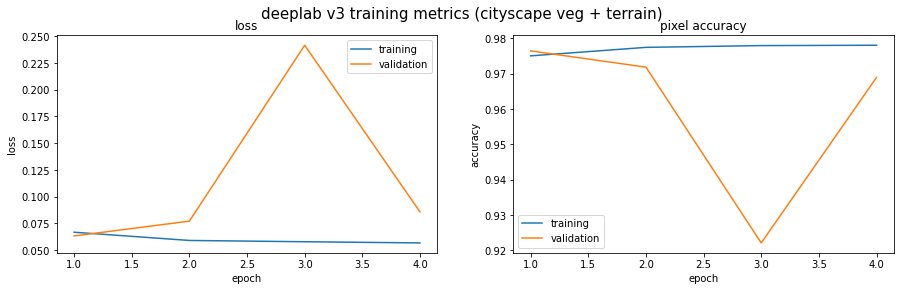

In [ ]:
train_losses = [0.0667,0.059, 0.0578, 0.0567]
val_losses = [0.06322, 0.07709, 0.2416, 0.0857] 

train_accs = [0.975, 0.9774, 0.9779, 0.978]
val_accs = [0.9764, 0.9718, 0.92208, 0.9689] 

epochs = 4
epochs_ = range(1,epochs+1)

# Displaying images and targets side by side
fig, axarr = plt.subplots(1, 2,figsize=(15,4))
fig.suptitle('deeplab v3 training metrics (cityscape veg + terrain)',fontsize=15)
axarr[0].plot(epochs_,train_losses,label='training')
axarr[0].plot(epochs_,val_losses,label='validation')
axarr[0].set_xlabel("epoch")
axarr[0].set_ylabel("loss")
axarr[0].legend()
axarr[0].set_title("loss")
axarr[1].plot(epochs_,train_accs,label='training')
axarr[1].plot(epochs_,val_accs,label='validation')
axarr[1].set_xlabel("epoch")
axarr[1].set_ylabel("accuracy")
axarr[1].legend()
axarr[1].set_title("pixel accuracy")
# axarr[2].plot(epochs_,train_ious,label='training')
# axarr[2].plot(epochs_,val_ious,label='validation')
# axarr[2].set_xlabel("epoch")
# axarr[2].set_ylabel("IoU")
# axarr[2].legend()
# axarr[2].set_title("IoU")


plt.show()


This is the loss & metrics for the network trained on both vegetation and terrain and on the 400x400 images

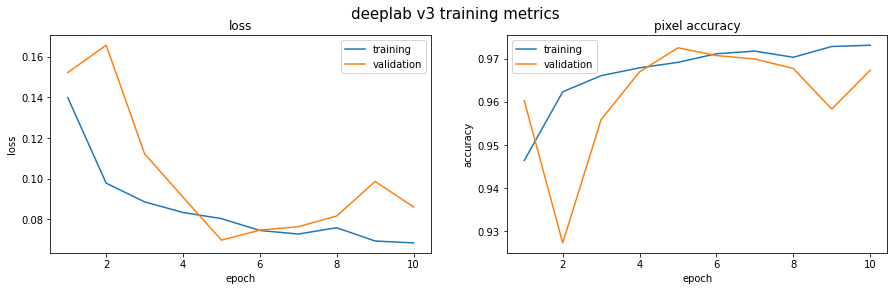

In [ ]:
train_losses = [0.1399, 0.09776, 0.08854, 0.08330, 0.08030, 0.07444, 0.0727, 0.0758, 0.069249, 0.06833]
val_losses = [0.152207, 0.16566, 0.1122, 0.09084, 0.06971, 0.07461, 0.0763, 0.0816, 0.0986, 0.0860 ] 

train_accs = [0.9464, 0.9623, 0.96605, 0.96786, 0.96913, 0.97112, 0.97173, 0.9703, 0.9728, 0.97309]
val_accs = [0.96023, 0.9273, 0.9559, 0.96692, 0.9725, 0.9707, 0.9699, 0.96771, 0.9583, 0.96730] 

epochs = 10
epochs_ = range(1,epochs+1)

# Displaying images and targets side by side
fig, axarr = plt.subplots(1, 2,figsize=(15,4))
fig.suptitle('deeplab v3 training metrics',fontsize=15)
axarr[0].plot(epochs_,train_losses,label='training')
axarr[0].plot(epochs_,val_losses,label='validation')
axarr[0].set_xlabel("epoch")
axarr[0].set_ylabel("loss")
axarr[0].legend()
axarr[0].set_title("loss")
axarr[1].plot(epochs_,train_accs,label='training')
axarr[1].plot(epochs_,val_accs,label='validation')
axarr[1].set_xlabel("epoch")
axarr[1].set_ylabel("accuracy")
axarr[1].legend()
axarr[1].set_title("pixel accuracy")
# axarr[2].plot(epochs_,train_ious,label='training')
# axarr[2].plot(epochs_,val_ious,label='validation')
# axarr[2].set_xlabel("epoch")
# axarr[2].set_ylabel("IoU")
# axarr[2].legend()
# axarr[2].set_title("IoU")


plt.show()

This is the loss for the tree-only network trained on the full sized images

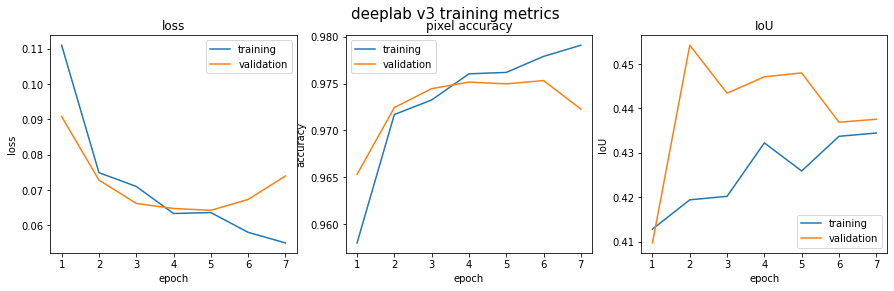

In [ ]:
train_losses = [0.111, 0.0749, 0.0710, 0.0633298, 0.0636, 0.0580, 0.055]
val_losses = [0.0908, 0.0728, 0.06619, 0.06475, 0.06423, 0.06732, 0.07396]

train_accs = [0.958, 0.9717, 0.97325, 0.97604, 0.97619, 0.9779, 0.97909]
val_accs = [0.965318, 0.972438, 0.97446, 0.975157, 0.97497, 0.97532, 0.97228]

train_ious = [0.4128, 0.4194, 0.420186, 0.4322144, 0.42589, 0.4337, 0.43444]
val_ious = [0.4097, 0.45420, 0.4434, 0.4471, 0.44797, 0.436868, 0.43754]

epochs = 7
epochs_ = range(1,epochs+1)

# Displaying images and targets side by side
fig, axarr = plt.subplots(1, 3,figsize=(15,4))
fig.suptitle('deeplab v3 training metrics',fontsize=15)
axarr[0].plot(epochs_,train_losses,label='training')
axarr[0].plot(epochs_,val_losses,label='validation')
axarr[0].set_xlabel("epoch")
axarr[0].set_ylabel("loss")
axarr[0].legend()
axarr[0].set_title("loss")
axarr[1].plot(epochs_,train_accs,label='training')
axarr[1].plot(epochs_,val_accs,label='validation')
axarr[1].set_xlabel("epoch")
axarr[1].set_ylabel("accuracy")
axarr[1].legend()
axarr[1].set_title("pixel accuracy")
axarr[2].plot(epochs_,train_ious,label='training')
axarr[2].plot(epochs_,val_ious,label='validation')
axarr[2].set_xlabel("epoch")
axarr[2].set_ylabel("IoU")
axarr[2].legend()
axarr[2].set_title("IoU")


plt.show()

## View predictions from best model

It appears that the model may have started overfitting after epoch 5, so I'll use the model from that epoch for my predictions.

In [ ]:
# Check to see if model and best model are the same here as well
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/models/model_v1.pth'
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/tree_models/round 3/best_model_tree.pth'
PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/tree_grass_1024/model-whole-epoch-1-09:30:52.013061.tar'


best_model = custom_DeepLabv3(num_classes)

# Load model from path
# best_model.load_state_dict(torch.load(PATH))

# If loading checkpoint
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/nature_models/round 2/model-whole-epoch-4-01:00:53.027089.tar'
checkpoint = torch.load(PATH)
best_model.load_state_dict(checkpoint['model_state_dict'])

# set to eval
best_model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

Feed in images from my val set to see how well my predictions match the labels.

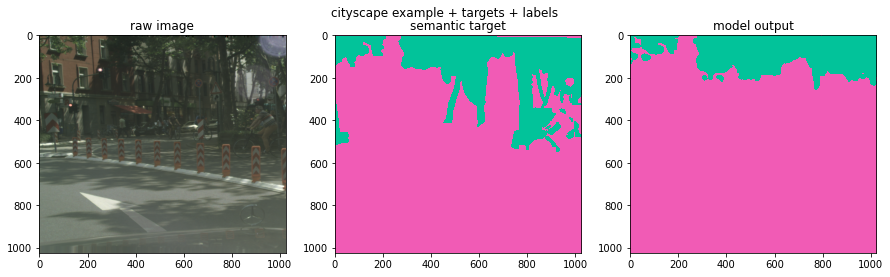

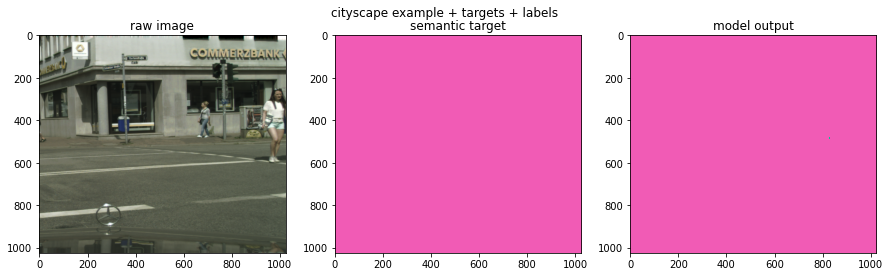

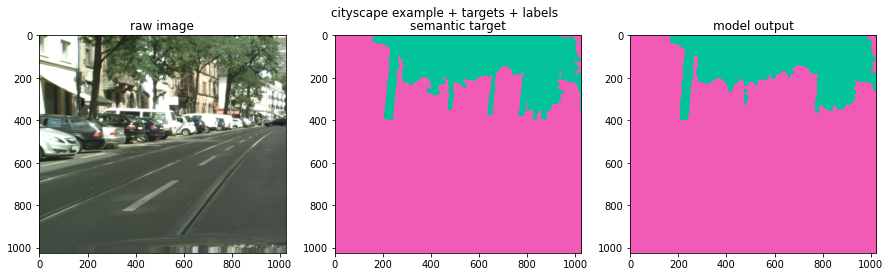

In [ ]:
# Load example
# best_model = model
for i in range(3):
  # img, label = train_data_full[i]
  img, label = val_data[i]
  img = img.unsqueeze(0).to(device)
  label = label.type(torch.LongTensor).to(device)
  # print(np.unique(label.cpu().numpy()))
  # make prediction
  best_model.eval()
  with torch.no_grad():
    outputs = best_model(img)
    output = outputs['out']
    aux = outputs['aux'] 
    preds = output.max(dim=1)[1].type(torch.LongTensor).to(device).squeeze()
    show_examples(img.squeeze(),label,preds) # unsqueeze here b/c I only have 1


Let's take a better look by overlaying our predictions onto the image.

https://stackoverflow.com/questions/62362807/plotting-multi-class-semantic-segmentation-transparent-overlays-over-rgb-image

or

https://stackoverflow.com/questions/31877353/overlay-an-image-segmentation-with-numpy-and-matplotlib



In [ ]:
def overlay_predictions(img,label):

    # I want to denormalize the image so it looks better
    inv_normalize = transforms.Normalize(
      mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
      std=[1/0.229, 1/0.224, 1/0.225]
    )
    img = inv_normalize(img)

    img_ = img.cpu().numpy().transpose(1,2,0)
    smnt_ = label.cpu().numpy()
    
    # Uncomment this for black and white
    # colors = ['green'] 
    # plt.figure(figsize=(10,6))
    # io.imshow(color.label2rgb(smnt_,img_,colors=colors,alpha=0.3,bg_label=0),aspect='auto')
    # plt.show()

    # Keeps color of background
    colors = [ "#f15bb5", "#02c39a"] 
    cmap = ListedColormap(colors)
    # Get the colormap colors
    my_cmap = cmap(np.arange(cmap.N))
    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 0.55, cmap.N)
    # Create new colormap
    cmap = ListedColormap(my_cmap)     

    plt.figure(figsize=(10,6))
    plt.axis('off')
    plt.imshow(img_)
    plt.imshow(smnt_, cmap=cmap) # interpolation='none'
    

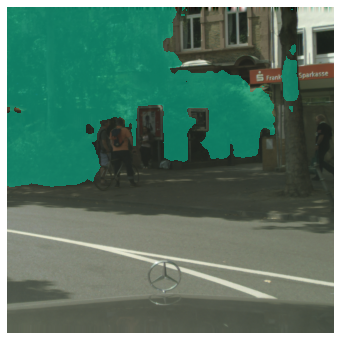

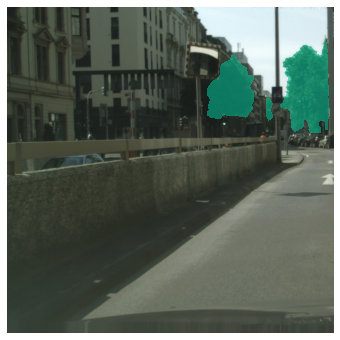

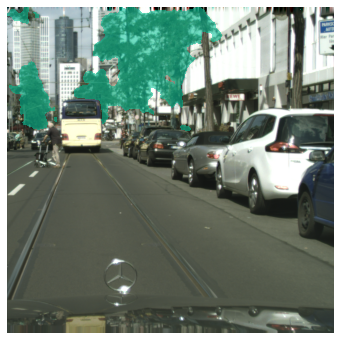

In [ ]:
for i in range(3):
  img, label = val_data[i+30]
  img = img.unsqueeze(0).to(device)
  label = label.type(torch.LongTensor).to(device)
  # make prediction
  best_model.eval()
  with torch.no_grad():
    outputs = best_model(img)
    output = outputs['out']
    aux = outputs['aux'] 
    preds = output.max(dim=1)[1].type(torch.LongTensor).to(device).squeeze()
    overlay_predictions(img.squeeze(),preds) # unsqueeze here b/c I only have 1
    del preds
    del label
    del img
    torch.cuda.empty_cache()

  # overlay_predictions(img.squeeze(),label)


## Green Value Index (GVI)

Function for calculating the GVI for a given image, (plus other metrics like IoU and pixel accuracy - will use for SLC images).

http://senseable.mit.edu/treepedia/treepedia_publication.pdf

The green view index for a point on a street is simply the sum of the "green" pixels in a given picture, divided by the total number of pixels in that picture. For each points its really $$ \frac{num of green pixels in all images}{total pixels in all images} x 100%$$

In [ ]:
def green_view_index(labels):
  '''
  Input: semantic labels
  Output: Green value index
  '''
  # Count all green pixels
  green_pix = 0
  all_pix = 0
  for label in labels:
    # print(label.shape,"gvi")
    green_pix += np.count_nonzero(label == 1)
    all_pix += label.shape[0] * label.shape[1]
  
  # Divide by all pixels
  return green_pix/all_pix * 100
  

Corrected IoU calculation + pixel accuracy 

In [ ]:
def get_metrics(labels,preds):
  '''
  input: Targets and model predictions
  output: IoU and pixelwise accuracy
  '''

  # Let's tree something else, just set all pixels not 1 in label to 0, then sum
  labels[labels != 1] = 0
  acc_sum = (preds == labels).sum(1).sum(1)
  all_sum = labels.shape[1] * labels.shape[2]
  acc = acc_sum / all_sum
  acc = np.mean(acc)
  # print(acc)

  # 2. calculate IoU metric: https://www.jeremyjordan.me/evaluating-image-segmentation-models/
  intersection = np.logical_and(labels, preds)
  # print(intersection.shape)
  union = np.logical_or(labels, preds)
  # print(union.shape)
  iou_score = intersection.sum(1).sum(1) / union.sum(1).sum(1)
  iou_score = np.mean(iou_score)
  # iou_score = np.sum(intersection) / np.sum(union)
  iou = iou_score
  # print(iou)
  return acc,iou



Plug in some labels to test GVI + IoU + pixel accuracy implementation

In [ ]:
for i in range(1):
  img, label = val_data[i+30]
  img = img.unsqueeze(0).to(device)
  label = label.type(torch.LongTensor).to(device)
  # make prediction
  # print("image",img)
  # print("image shape",img.shape)
  # print("label",label)
  print(label.shape)
  best_model.eval()
  with torch.no_grad():
    outputs = best_model(img)
    output = outputs['out']
    # aux = outputs['aux'] 
    preds = output.max(dim=1)[1].type(torch.LongTensor).to(device).squeeze()
    # overlay_predictions(img.squeeze(),preds) # unsqueeze here b/c I only have 1
    preds = preds.unsqueeze(0)
    label = label.unsqueeze(0)
    preds_cpu = preds.cpu().numpy()
    label_cpu = label.cpu().numpy()
    del preds
    del label
    del img
    torch.cuda.empty_cache()
    GVI_preds = green_view_index(preds_cpu)
    GVI_label = green_view_index(label_cpu)
    acc, iou = get_metrics(label_cpu,preds_cpu)
    print('GVI preds:',GVI_preds,'GVI labels:',GVI_label)
    print('Acc:',acc,'IoU:',iou)
  


torch.Size([1024, 1024])
GVI preds: 18.121910095214844 GVI labels: 22.153949737548828
Acc: 0.9310064315795898 IoU: 0.7075007884075785


# Training/testing on hand labeled GSV images

## Load and test hand - annotated image

GVI preds: 10.5525 GVI labels: 37.049375
Acc: 0.65599375 IoU: 0.16098594555044055


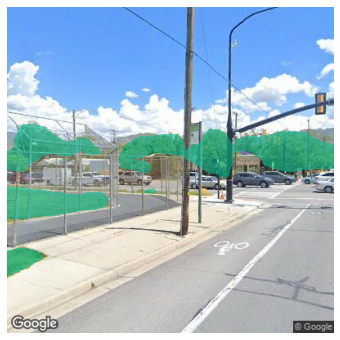

In [ ]:
# How to load just single image, and what format do I need it in? Think a PIL object or something.

LABEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_test_data/102_0.png'
IM_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_test_data/4688_60.jpeg'

# I just need to feed in a tensor of size image shape torch.Size([1, 3, 1024, 1700])
# And label can really be whatever

# NEED TO NORMALIZE MY INPUT IMAGES
ToTensor = transforms.ToTensor()
Norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img = Image.open(IM_PATH)
label = Image.open(LABEL_PATH)
# plt.imshow(img)
img = Norm(ToTensor(img).unsqueeze(0).to(device))
target = ToTensor(label)
target[target != 0] = 1
target = target[0].unsqueeze(0)
# print("input shape",input.shape)
# print("target shape",target.shape)

best_model.eval()
with torch.no_grad():
  outputs = best_model(img)
  output = outputs['out']
  # print("output shape",output.shape)
  # print("output:",output)
  preds = output.max(dim=1)[1].type(torch.LongTensor)
  # print("preds shape",preds.shape)
  preds_cpu = preds.cpu().numpy()
  label_cpu = target.numpy()
  # print("preds",preds_cpu)
  # print("target",label_cpu)

  overlay_predictions(img.squeeze(),preds.squeeze()) 

  # clear stuff from GPU
  del img
  del output
  del outputs
  del preds
  torch.cuda.empty_cache()

  # Compute metrics
  GVI_preds = green_view_index(preds_cpu)
  GVI_label = green_view_index(label_cpu)
  acc, iou = get_metrics(label_cpu,preds_cpu)
  print('GVI preds:',GVI_preds,'GVI labels:',GVI_label)
  print('Acc:',acc,'IoU:',iou)
  
  
# View img + label + prediction
# fig, axarr = plt.subplots(1, 3,figsize=(15,4))
# fig.suptitle('slc example + targets + labels')
# axarr[0].imshow(img_,aspect='auto')
# axarr[0].set_title("raw image")
# axarr[1].imshow(target_,vmin=0, vmax=len(cmap.colors), cmap=cmap,aspect='auto')
# axarr[1].set_title("semantic target")
# axarr[2].imshow(smnt_,vmin=0, vmax=len(cmap.colors), cmap=cmap,aspect='auto')
# axarr[2].set_title("model output")

Looks great!!!!

## Create pytorch dataset for all my slc images

Seems like this may be the most efficient way to load them into my model.

In [ ]:
class SLCData(Dataset):
    """
    SLC GSV data.
      Loads all of the data from the slc set. Doesn't include labels,
      Just raw images. 
    """

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): path to the csv file used for ids + lats and longs 
            root_dir (string): Root directory w/ image folders
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.locations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.locations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Id of the point
        id = self.locations.iloc[idx,0]
        location = self.locations.iloc[idx,1:3]
        # print(location)

        img_0 = Image.open(self.root_dir + 'heading0/{}.jpeg'.format(id))
        img_60 = Image.open(self.root_dir + 'heading60/{}.jpeg'.format(id))
        img_300 = Image.open(self.root_dir + 'heading300/{}.jpeg'.format(id))
        img_120 = Image.open(self.root_dir + 'heading120/{}.jpeg'.format(id))
        img_180 = Image.open(self.root_dir + 'heading180/{}.jpeg'.format(id))
        img_240 = Image.open(self.root_dir + 'heading240/{}.jpeg'.format(id))

        # Changing to tensor here b/c you can't use transforms = transforms.ToTensor() w/ non-image data
        images = [img_0, img_60, img_300, img_120, img_180, img_240]

        # handle transforms
        if self.transform is not None:
          for i,im in enumerate(images):
            images[i] = self.transform(im)

        return images,location

In [ ]:
root = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc data/'
csv_file = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc data/sample_100m.csv'

# Training transforms
train_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for pretrained models
])

slc_data = SLCData(csv_file, root, transform=train_transforms)

print("slc full dataset: ",len(slc_data))

slc full dataset:  9522


Viewing slc dataset output

In [ ]:
for i in range(1):
  imgs, locs = slc_data[i]
  print(locs)
  # for im in imgs:
  #   plt.figure()
  #   plt.imshow(im.transpose(0,2))
  
    

lat     40.758448
lon   -111.940213
Name: 0, dtype: float64


## Pytorch dataset for test set as well

In [ ]:
class SLCTrainData(Dataset):
    """
    SLC GSV labeled data.
      Loads all of the data from the slc train set. Inlcudes labels and raw 
      images.
    """

    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): path to the csv file used for ids + lats and longs 
            root_dir (string): Root directory w/ image folders
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.indices = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Id of the point
        id = self.indices.iloc[idx,1]
        # location = self.locations.iloc[idx,1:3]
        # print(location)

        img_0 = Image.open(self.root_dir + '{}_0.jpeg'.format(id)).convert('RGB')
        lbl_0 = Image.open(self.root_dir + '{}_0.png'.format(id))

        img_60 = Image.open(self.root_dir + '{}_60.jpeg'.format(id)).convert('RGB')
        lbl_60 = Image.open(self.root_dir + '{}_60.png'.format(id))

        img_300 = Image.open(self.root_dir + '{}_300.jpeg'.format(id)).convert('RGB')
        lbl_300 = Image.open(self.root_dir + '{}_300.png'.format(id))

        img_120 = Image.open(self.root_dir + '{}.jpeg'.format(id)).convert('RGB')
        lbl_120 = Image.open(self.root_dir + '{}.png'.format(id))

        img_180 = Image.open(self.root_dir + '{} 2.jpeg'.format(id)).convert('RGB')
        lbl_180 = Image.open(self.root_dir + '{} 2.png'.format(id))

        img_240 = Image.open(self.root_dir + '{} 3.jpeg'.format(id)).convert('RGB')
        lbl_240 = Image.open(self.root_dir + '{} 3.png'.format(id))

        images = [img_0, img_60, img_300, img_120, img_180, img_240]
        labels = [lbl_0, lbl_60, lbl_300, lbl_120, lbl_180, lbl_240]

        # Changing to tensor here b/c you can't use transforms = transforms.ToTensor() w/ non-image data
        # sample = {'0': img_0, '60': img_60, '300': img_300}

        # May need to adjust this transform bit
        if self.transform is not None:
          for i,im in enumerate(images):
            images[i] = self.transform(im)

        if self.target_transform is not None:
          for i,label in enumerate(labels):
            labels[i] = self.target_transform(label)
            # change labels to numpy and set classes to 1
            lbl = labels[i].numpy()
            lbl[lbl != 0] = 1
            # print("lbl shape",lbl.shape)
            # change back to tensor
            labels[i] = torch.Tensor(lbl).squeeze()
            


        return images,labels

## Test dataset

In the future I should name the files better so I could have my test and val datasets be the same.

In [ ]:
class SLCTestData(Dataset):
    """
    SLC GSV labeled data.
      Loads all of the data from the slc test set. Inlcudes labels and raw 
      images.
    """

    def __init__(self, csv_file, root_dir, transform=None, target_transform=None):
        """
        Args:
            csv_file (string): path to the csv file used for ids + lats and longs 
            root_dir (string): Root directory w/ image folders
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.indices = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Id of the point
        id = self.indices.iloc[idx,1]
        # location = self.locations.iloc[idx,1:3]
        # print(location)

        img_0 = Image.open(self.root_dir + '{}.jpeg'.format(id)).convert('RGB')
        lbl_0 = Image.open(self.root_dir + '{}.png'.format(id))

        img_60 = Image.open(self.root_dir + '{} 2.jpeg'.format(id)).convert('RGB')
        lbl_60 = Image.open(self.root_dir + '{} 2.png'.format(id))

        img_300 = Image.open(self.root_dir + '{} 3.jpeg'.format(id)).convert('RGB')
        lbl_300 = Image.open(self.root_dir + '{} 3.png'.format(id))

        img_120 = Image.open(self.root_dir + '{} 4.jpeg'.format(id)).convert('RGB')
        lbl_120 = Image.open(self.root_dir + '{} 4.png'.format(id))

        img_180 = Image.open(self.root_dir + '{} 5.jpeg'.format(id)).convert('RGB')
        lbl_180 = Image.open(self.root_dir + '{} 5.png'.format(id))

        img_240 = Image.open(self.root_dir + '{} 6.jpeg'.format(id)).convert('RGB')
        lbl_240 = Image.open(self.root_dir + '{} 6.png'.format(id))

        images = [img_0, img_60, img_300, img_120, img_180, img_240]
        labels = [lbl_0, lbl_60, lbl_300, lbl_120, lbl_180, lbl_240]

        # Changing to tensor here b/c you can't use transforms = transforms.ToTensor() w/ non-image data
        # sample = {'0': img_0, '60': img_60, '300': img_300}

        # May need to adjust this transform bit
        if self.transform is not None:
          for i,im in enumerate(images):
            images[i] = self.transform(im)

        if self.target_transform is not None:
          for i,label in enumerate(labels):
            labels[i] = self.target_transform(label)
            # change labels to numpy and set classes to 1
            lbl = labels[i].numpy()
            lbl[lbl != 0] = 1
            # print("lbl shape",lbl.shape)
            # change back to tensor
            labels[i] = torch.Tensor(lbl).squeeze()
            


        return images,labels

## Examine SLC Train Dataset

I want to view my training images along with their labels

In [ ]:
root = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_train_full/'
csv_file = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_train_full/train_index.csv'

test_root = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_val/'
test_csv_file = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_val/test_indices.csv'

# Training transforms
train_transforms = transforms.Compose([
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # needed for pretrained models
])

#target transforms
target_transforms = transforms.Compose([
    # transforms.Resize(512),
    # transforms.RandomCrop(size=(im_h,im_w)), # This is essentially doing my resizing here
    # transforms.RandomHorizontalFlip()
    transforms.ToTensor()
])


slc_train = SLCTrainData(csv_file, root, transform=train_transforms, target_transform=target_transforms)
slc_test = SLCTestData(test_csv_file, test_root, transform=train_transforms, target_transform=target_transforms)

print("slc train set length: ",len(slc_train))
print("slc test set length: ",len(slc_test))

slc train set length:  25
slc test set length:  10


Check out some images with my hand labels overlayed

In [ ]:
for i in range(1):
  imgs, labels = slc_train[i]
  # print(imgs,labels)
  for i,im in enumerate(imgs):
    # print(i)
    overlay_predictions(im,labels[i].squeeze()) 
    


## Retrain model with my hand labeled SLC data

Our results for predicting grass + trees didn't do very well, so I'll feed in some hand labeled training images from our slc data in hopes of improving our model a bit. 

Note: one explanation for things not working so well is that I'm forcing grass and trees to belong in the same class, may be better to make the model have three classes: grass, trees, neither. 

## Creat data loader

In [ ]:
# Create data loaders
batch_size = 5

# Full dataset
train_loader = DataLoader(
  slc_train, batch_size=batch_size, shuffle=True, drop_last=True) #, num_workers=2)

val_loader = DataLoader(
    slc_test, batch_size=batch_size, shuffle=False, drop_last=True) #, num_workers=2)

## Load model + optimizer etc.

In [ ]:
# Using my best performing tree + grass model for this
PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/nature_models/resnet50_1024/best_tree_grass.tar'

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


<All keys matched successfully>

## Altered val helper to handle different dataset

Currently don't have a val set, but will make a small one after I see training works somewhat

In [ ]:
# Validation helper

def validate_phase(val_dl,best_acc,best_wts):
    # Put the model in eval mode
    model.eval()
    losses = []
    accuracies = []
    ious = []
    epoch_start = time.time()
    # Think this helps....
    with torch.no_grad():
      for i, batch in enumerate(tqdm(val_dl)):
          inputs = batch[0]
          labels = batch[1]
          for idx,img in enumerate(inputs):
            input, target = img.to(device), labels[idx].type(torch.LongTensor).to(device)
            # print("inputs shape:",inputs.shape)
            # print("labels shape:",labels.shape)
            # print("unique labels: ",np.unique(labels.cpu().numpy()))
            # print("labels",labels)

            outputs = model(input)           # 2. Run the model
            output = outputs['out']
            # aux = outputs['aux']
            # print("output shape:",output.shape)
            # print("aux shape:",aux.shape)
            # print("output:",output)

            # Need to refactor the output to return argmax for each pixel
            preds = output.max(dim=1)[1].type(torch.LongTensor).to(device)
            # print("preds shape: ",preds.shape)
            # print("predictions:",preds)
            

            # I think outputs and labels need to be the same shape obviously,
            # but outputs need to have an extram dim:
            # https://discuss.pytorch.org/t/valueerror-expected-target-size-32-7-got-torch-size-32/42409/4

            loss = criterion(output, target) # 3. Calculate loss
            losses.append(loss.item())

            # May be helpful for other loss: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
            # outputs, aux_outputs = model(inputs)
            # loss1 = criterion(outputs, labels)
            # loss2 = criterion(aux_outputs, labels)
            # loss = loss1 + 0.4*loss2
            
            # Convert target and predictions to numpy
            labels_np = target.cpu().numpy()
            preds_np = preds.cpu().numpy()

            # 4. Calculate pixel accuracy: https://github.com/CSAILVision/semantic-segmentation-pytorch/blob/master/mit_semseg/utils.py
            # This needs to be by batch
            valid = (labels_np != 255)
            acc_sum = (valid * (preds_np == labels_np)).sum(1).sum(1)
            valid_sum = valid.sum(1).sum(1)
            acc = acc_sum / valid_sum
            accuracies.append(np.mean(acc))

            # 5. calculate IoU metric: https://www.jeremyjordan.me/evaluating-image-segmentation-models/
            intersection = np.logical_and(labels_np, preds_np)
            # print(intersection.shape)
            union = np.logical_or(labels_np, preds_np)
            # print(union.shape)
            iou_score = intersection.sum(1).sum(1) / (union.sum(1).sum(1) + 0.00001)
            iou_score = np.mean(iou_score)
            # iou_score = np.sum(intersection) / np.sum(union)
            ious.append(iou_score)

            # print('[VAL] Loss: {:.4f} Acc: {:.4f}'.format(loss.item(), np.mean(acc)))
            # if i == 0:
            #   show_examples(inputs[0],labels[0],preds[0].squeeze())
            #   break
          
      
      # epoch_loss = np.sqrt(sum(losses) / len(losses))
      epoch_loss = np.mean(losses)
      epoch_acc = np.mean(accuracies)
      epoch_iou = np.mean(ious)
      epoch_time = time.time() - epoch_start
      # deep copy the model
      # if epoch_acc > best_acc:
      #     best_acc = epoch_acc
      #     best_wts = copy.deepcopy(model.state_dict())
      #     # save
      #     MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-val-epoch-{}-{}.pth'.format(epoch+1,datetime.now().time())
      #     torch.save(model.state_dict(), MODEL_PATH)

      print("[VAL] Epoch: {} Loss: {} Pixel Acc: {} IoU: {} Time: {:.0f}:{:.0f}".format(epoch+1, epoch_loss,
                                                                  epoch_acc,
                                                                  epoch_iou,
                                                                  epoch_time // 60, 
                                                                  epoch_time % 60))                                                                
    return epoch_loss, epoch_acc, epoch_iou, best_acc, best_wts

# epoch = 0
# best_acc = 0.9
# best_wts = None
# loss, acc, iou, best_acc, best_wts = validate_phase(val_loader,best_acc,best_wts)
# print(loss,acc,iou,best_acc,best_wts)

## Altered Training helper to accomodate new dataset

In [ ]:
for i, batch in enumerate(tqdm(train_loader)):
    inputs = batch[0]
    labels = batch[1]
    print(len(batch))
    print(len(inputs))
    print(len(labels))
    for idx,img in enumerate(inputs):
      input, target = img.to(device), labels[idx].type(torch.LongTensor).to(device)
      print(input.shape)
      print(target.shape)

    
    if i == 0:
      break

2
6
6
torch.Size([2, 3, 400, 400])
torch.Size([2, 400, 400])
torch.Size([2, 3, 400, 400])
torch.Size([2, 400, 400])
torch.Size([2, 3, 400, 400])
torch.Size([2, 400, 400])
torch.Size([2, 3, 400, 400])
torch.Size([2, 400, 400])
torch.Size([2, 3, 400, 400])
torch.Size([2, 400, 400])
torch.Size([2, 3, 400, 400])
torch.Size([2, 400, 400])


In [ ]:
def train_phase(train_dl):
    model.train()
    losses = []
    accuracies = []
    ious = []
    epoch_start = time.time()
    with torch.enable_grad(): # resets grads
      for i, batch in enumerate(tqdm(train_dl)):
          inputs = batch[0]
          labels = batch[1]
          for idx,img in enumerate(inputs):
            input, target = img.to(device), labels[idx].type(torch.LongTensor).to(device)
            # print(input.shape)
            # print(target.shape)

            optimizer.zero_grad()             # 1. Zero the parameter gradients
            outputs = model(input)           # 2. Run the model
            output = outputs['out']
            # aux = outputs['aux']          

            loss = criterion(output, target) # 3. Calculate loss
            losses.append(loss.item())
            

            loss.backward()                   # 4. Backward propagate the loss
            optimizer.step()                  # 5. Optimize the network

            # Need to refactor the output to return argmax for each pixel
            preds = output.max(dim=1)[1].type(torch.LongTensor).to(device)

            # Convert target and predictions to numpy
            labels_np = target.cpu().numpy()
            preds_np = preds.cpu().numpy()
            
            # 4. Calculate pixel accuracy: https://github.com/CSAILVision/semantic-segmentation-pytorch/blob/master/mit_semseg/utils.py
            # This needs to be by batch
            valid = (labels_np != 255)
            acc_sum = (valid * (preds_np == labels_np)).sum(1).sum(1)
            valid_sum = valid.sum(1).sum(1)
            acc = acc_sum / valid_sum
            accuracies.append(np.mean(acc))

            # 5. calculate IoU metric: https://www.jeremyjordan.me/evaluating-image-segmentation-models/
            intersection = np.logical_and(labels_np, preds_np)
            # print(intersection.shape)
            union = np.logical_or(labels_np, preds_np)
            # print(union.shape)
            iou_score = intersection.sum(1).sum(1) / (union.sum(1).sum(1) + 0.00001)
            iou_score = np.mean(iou_score)
            # iou_score = np.sum(intersection) / np.sum(union)
            ious.append(iou_score)

            # print('[TRN] Loss: {:.4f} Acc: {:.4f}'.format(loss.item(), np.mean(acc)))
            # if i == 0:
            #   break

    # save
    # MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-trn-epoch-{}-{}.pth'.format(epoch+1,datetime.now().time())
    # MODEL_PATH_WHOLE = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/model-whole-epoch-{}-{}.tar'.format(epoch+1,datetime.now().time())
    # torch.save(model.state_dict(), MODEL_PATH)
    # torch.save({
    #         'epoch': epoch+1,
    #         'model_state_dict': model.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict()
    #         }, MODEL_PATH_WHOLE)

    epoch_loss = np.mean(losses)
    epoch_acc = np.mean(accuracies)
    epoch_iou = np.mean(ious)
    epoch_time = time.time() - epoch_start
    print("[TRN] Epoch: {} Loss: {} Pixel Acc: {} IoU: {} Time: {:.0f}:{:.0f}".format(epoch+1,
                                                                epoch_loss, 
                                                                epoch_acc,
                                                                epoch_iou,   
                                                                epoch_time // 60, 
                                                                epoch_time % 60))
    return epoch_loss, epoch_acc, epoch_iou

# epoch = 0
# loss, acc, iou = train_phase(train_loader)
# print(loss,acc,iou)

## Run training 

In [ ]:
# Init best model weights and accuracy
# best_wts = copy.deepcopy(model.state_dict())
best_wts = None
best_acc = 0
epochs = 25

train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

for epoch in range(epochs):
    # Train and val
    train_loss, train_acc, train_iou = train_phase(train_loader)
    val_loss, val_acc, val_iou, best_acc, best_wts = validate_phase(val_loader,best_acc,best_wts)

    # Adjust learning rate if needs be
    scheduler.step(train_loss)
    # scheduler.step(val_loss)

    # store train values    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    train_ious.append(train_iou)

    # store val values
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    val_ious.append(val_iou)


[TRN] Epoch: 1 Loss: 0.38465183873971304 Pixel Acc: 0.895285375 IoU: 0.6784292812973391 Time: 0:18



[VAL] Epoch: 1 Loss: 0.1246367401132981 Pixel Acc: 0.9500336458333334 IoU: 0.6996629586906913 Time: 1:20



[TRN] Epoch: 2 Loss: 0.18661011308431624 Pixel Acc: 0.9290639583333332 IoU: 0.7727368298340543 Time: 0:18



[VAL] Epoch: 2 Loss: 0.1047207610681653 Pixel Acc: 0.9582488541666665 IoU: 0.7008581536046714 Time: 0:2



[TRN] Epoch: 3 Loss: 0.15398176088929177 Pixel Acc: 0.9385170000000002 IoU: 0.7936579859904255 Time: 0:18



[VAL] Epoch: 3 Loss: 0.102057500431935 Pixel Acc: 0.9608833333333333 IoU: 0.7275756281410222 Time: 0:2



[TRN] Epoch: 4 Loss: 0.15138008793195087 Pixel Acc: 0.9415942083333333 IoU: 0.7967917291800635 Time: 0:18



[VAL] Epoch: 4 Loss: 0.09507621483256419 Pixel Acc: 0.9615880208333332 IoU: 0.722173626538698 Time: 0:2



[TRN] Epoch: 5 Loss: 0.13288642714420953 Pixel Acc: 0.9460772083333334 IoU: 0.8129156815821135 Time: 0:18



[VAL] Epoch: 5 Loss: 0.09879452517877023 Pixel Acc: 0.9600485416666666 IoU: 0.7262828439548327 Time: 0:2



[TRN] Epoch: 6 Loss: 0.13022015703221163 Pixel Acc: 0.948542 IoU: 0.8151003795241443 Time: 0:18



[VAL] Epoch: 6 Loss: 0.10102991666644812 Pixel Acc: 0.9607218750000001 IoU: 0.7159494741311532 Time: 0:2



[TRN] Epoch: 7 Loss: 0.12035910313328108 Pixel Acc: 0.9519959999999997 IoU: 0.8217152038502211 Time: 0:18



[VAL] Epoch: 7 Loss: 0.0927675049751997 Pixel Acc: 0.9616345833333333 IoU: 0.7429243771790972 Time: 0:2



[TRN] Epoch: 8 Loss: 0.10995465728143851 Pixel Acc: 0.9552823333333333 IoU: 0.8354769894399066 Time: 0:18



[VAL] Epoch: 8 Loss: 0.09574253577739 Pixel Acc: 0.9607715625000001 IoU: 0.7352437232595519 Time: 0:2



[TRN] Epoch: 9 Loss: 0.10398478383819262 Pixel Acc: 0.9571599583333332 IoU: 0.8394067751252744 Time: 0:18



[VAL] Epoch: 9 Loss: 0.09204129284868638 Pixel Acc: 0.9620103125 IoU: 0.7388082029551367 Time: 0:2



[TRN] Epoch: 10 Loss: 0.10506546571850776 Pixel Acc: 0.9569195416666666 IoU: 0.8382922629035229 Time: 0:18



[VAL] Epoch: 10 Loss: 0.09304277257372935 Pixel Acc: 0.9612378125 IoU: 0.7399791598306898 Time: 0:2



[TRN] Epoch: 11 Loss: 0.10010314558943113 Pixel Acc: 0.9587080833333332 IoU: 0.848488336591272 Time: 0:18



[VAL] Epoch: 11 Loss: 0.0935684513921539 Pixel Acc: 0.9601876041666667 IoU: 0.7372962546063814 Time: 0:2



[TRN] Epoch: 12 Loss: 0.09470564151803652 Pixel Acc: 0.961150125 IoU: 0.8529571258592458 Time: 0:18



[VAL] Epoch: 12 Loss: 0.09183154565592606 Pixel Acc: 0.9620190625 IoU: 0.7419999581235676 Time: 0:2



[TRN] Epoch: 13 Loss: 0.09411126424868901 Pixel Acc: 0.9614576666666668 IoU: 0.8579144962620734 Time: 0:18



[VAL] Epoch: 13 Loss: 0.09154185373336077 Pixel Acc: 0.9623008333333333 IoU: 0.7369422607085232 Time: 0:2



[TRN] Epoch: 14 Loss: 0.0892292449871699 Pixel Acc: 0.9637453750000001 IoU: 0.8608435650593752 Time: 0:18



[VAL] Epoch: 14 Loss: 0.09291176187495391 Pixel Acc: 0.9618680208333333 IoU: 0.7408942545821602 Time: 0:2



[TRN] Epoch: 15 Loss: 0.08835043894747893 Pixel Acc: 0.9640309583333333 IoU: 0.8583601311917609 Time: 0:18



[VAL] Epoch: 15 Loss: 0.09245214518159628 Pixel Acc: 0.9619601041666667 IoU: 0.7454064508976329 Time: 0:2



[TRN] Epoch: 16 Loss: 0.08822660607596239 Pixel Acc: 0.9637698333333334 IoU: 0.8658913805204178 Time: 0:18



[VAL] Epoch: 16 Loss: 0.09278001791487138 Pixel Acc: 0.9622253124999999 IoU: 0.7341977539852075 Time: 0:2



[TRN] Epoch: 17 Loss: 0.0887206876029571 Pixel Acc: 0.9640704999999999 IoU: 0.8626962353667074 Time: 0:18



[VAL] Epoch: 17 Loss: 0.10113910523553689 Pixel Acc: 0.9586066666666667 IoU: 0.727915502310836 Time: 0:2



[TRN] Epoch: 18 Loss: 0.0825933621575435 Pixel Acc: 0.9662397083333334 IoU: 0.8663258880467576 Time: 0:18



[VAL] Epoch: 18 Loss: 0.0949067718659838 Pixel Acc: 0.9615546875 IoU: 0.7377195974286127 Time: 0:2



[TRN] Epoch: 19 Loss: 0.07781412986417612 Pixel Acc: 0.9683255416666666 IoU: 0.8768127648860963 Time: 0:18



[VAL] Epoch: 19 Loss: 0.09310924882690112 Pixel Acc: 0.9629970833333332 IoU: 0.7433402392275151 Time: 0:2



[TRN] Epoch: 20 Loss: 0.0734791785478592 Pixel Acc: 0.9700972916666668 IoU: 0.8837582612117887 Time: 0:18



[VAL] Epoch: 20 Loss: 0.09455615965028603 Pixel Acc: 0.9618021875 IoU: 0.7395335138306155 Time: 0:2



[TRN] Epoch: 21 Loss: 0.07241240752240022 Pixel Acc: 0.9709011666666666 IoU: 0.8882956298486984 Time: 0:18



[VAL] Epoch: 21 Loss: 0.11213235991696517 Pixel Acc: 0.958124375 IoU: 0.7215318776938383 Time: 0:2



[TRN] Epoch: 22 Loss: 0.07491533805926641 Pixel Acc: 0.9696311666666665 IoU: 0.8787025108381923 Time: 0:18



[VAL] Epoch: 22 Loss: 0.10275433616091807 Pixel Acc: 0.9593044791666666 IoU: 0.7405896382722196 Time: 0:2



[TRN] Epoch: 23 Loss: 0.0712049052119255 Pixel Acc: 0.9707439999999999 IoU: 0.8880677577836291 Time: 0:18



[VAL] Epoch: 23 Loss: 0.09845212381333113 Pixel Acc: 0.9618010416666666 IoU: 0.7214788376804099 Time: 0:2



[TRN] Epoch: 24 Loss: 0.06606246853868167 Pixel Acc: 0.9730997083333334 IoU: 0.8934874515026858 Time: 0:18



[VAL] Epoch: 24 Loss: 0.09619273835172255 Pixel Acc: 0.9618960416666669 IoU: 0.7319395156602438 Time: 0:2



[TRN] Epoch: 25 Loss: 0.06949577281872431 Pixel Acc: 0.9718027499999999 IoU: 0.8915981220587319 Time: 0:18



[VAL] Epoch: 25 Loss: 0.10073629083732764 Pixel Acc: 0.9617873958333333 IoU: 0.7484985624496182 Time: 0:2


## Save model

In [ ]:
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/slc-nature-{}.pth'.format('v2-25-epochs')
torch.save(model.state_dict(), MODEL_PATH)


## Examine model by viewing predictions alongside target labels

In [ ]:

best_model = model

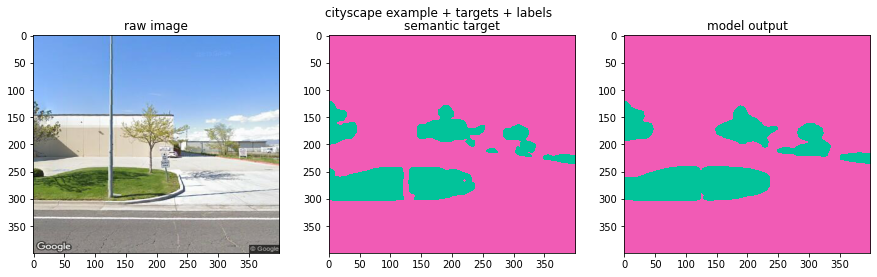

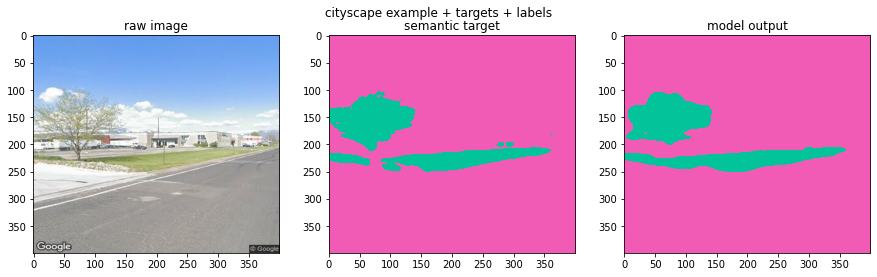

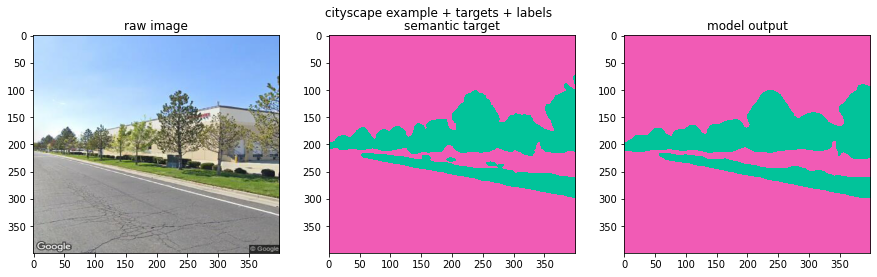

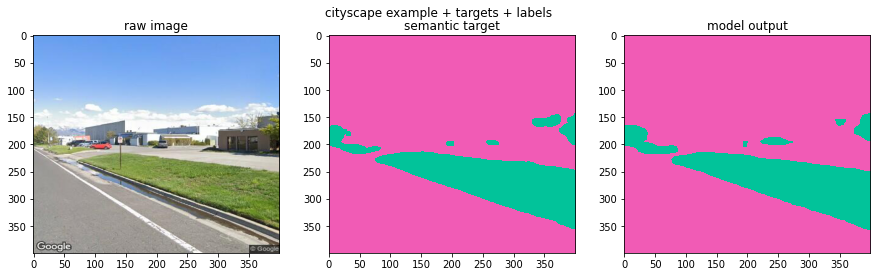

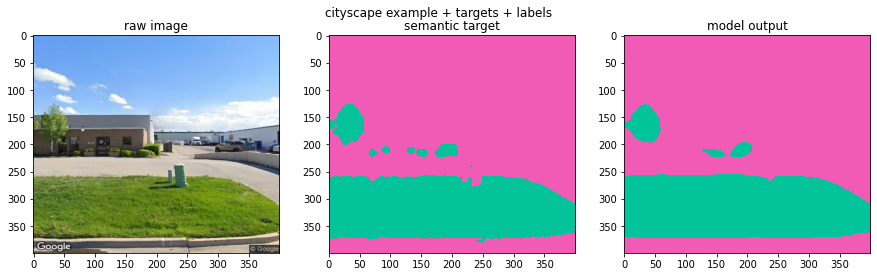

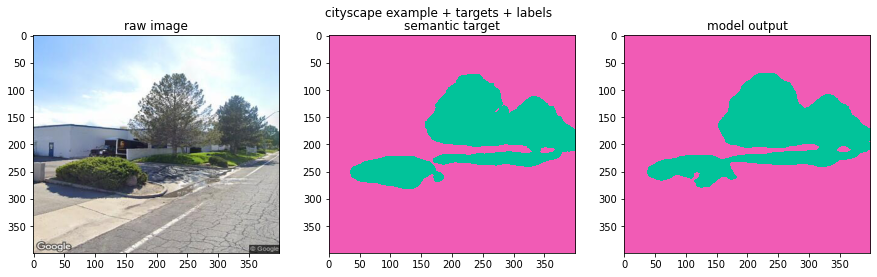

In [ ]:
# Load examples

for i in range(1):
  # img, label = train_data_full[i]
  images, labels = slc_test[i+4]
  for idx,img in enumerate(images):
    label = labels[idx]
    img = img.unsqueeze(0).to(device)
    label = label.type(torch.LongTensor).to(device)
    # print(np.unique(label.cpu().numpy()))
    # make prediction
    best_model.eval()
    with torch.no_grad():
      outputs = best_model(img)
      output = outputs['out']
      aux = outputs['aux'] 
      preds = output.max(dim=1)[1].type(torch.LongTensor).to(device).squeeze()
      show_examples(img.squeeze(),label,preds) # unsqueeze here b/c I only have 1


## Overlay predictions

In [ ]:
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/slc-nature-v1-10-epochs.pth'
PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/slc-nature-v2-25-epochs.pth'


best_model = custom_DeepLabv3(num_classes)

# Load model from path
best_model.load_state_dict(torch.load(PATH))

# If loading checkpoint
# PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/saved_models/checkpoints/nature_models/round 2/model-whole-epoch-4-01:00:53.027089.tar'
# checkpoint = torch.load(PATH)
# best_model.load_state_dict(checkpoint['model_state_dict'])

# set to eval
best_model.eval()


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

GVI preds: 74.56 GVI labels: 59.13375
Acc: 0.8014875 IoU: 0.7414275945162656


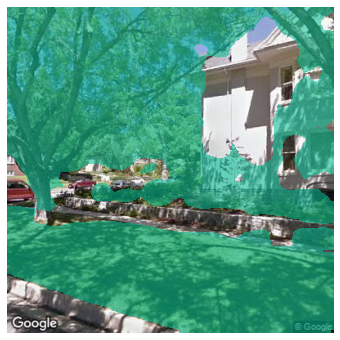

In [ ]:
# How to load just single image, and what format do I need it in? Think a PIL object or something.

# LABEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_test_data/102_0.png'
# IM_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_test_data/102_0.jpeg'

LABEL_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_val/200 2.png'
IM_PATH = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/slc_val/200 2.jpeg'

# I just need to feed in a tensor of size image shape torch.Size([1, 3, 1024, 1700])
# And label can really be whatever

# NEED TO NORMALIZE MY INPUT IMAGES
ToTensor = transforms.ToTensor()
Norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img = Image.open(IM_PATH)
label = Image.open(LABEL_PATH)
# plt.imshow(img)
img = Norm(ToTensor(img).unsqueeze(0).to(device))
target = ToTensor(label)
target[target != 0] = 1
target = target[0].unsqueeze(0)
# print("input shape",input.shape)
# print("target shape",target.shape)

best_model.eval()
with torch.no_grad():
  outputs = best_model(img)
  output = outputs['out']
  # print("output shape",output.shape)
  # print("output:",output)
  preds = output.max(dim=1)[1].type(torch.LongTensor)
  # print("preds shape",preds.shape)
  preds_cpu = preds.cpu().numpy()
  label_cpu = target.numpy()
  # print("preds",preds_cpu)
  # print("target",label_cpu)

  overlay_predictions(img.squeeze(),preds.squeeze()) 

  # clear stuff from GPU
  del img
  del output
  del outputs
  del preds
  torch.cuda.empty_cache()

  # Compute metrics
  GVI_preds = green_view_index(preds_cpu)
  GVI_label = green_view_index(label_cpu)
  acc, iou = get_metrics(label_cpu,preds_cpu)
  print('GVI preds:',GVI_preds,'GVI labels:',GVI_label)
  print('Acc:',acc,'IoU:',iou)
  
  
# View img + label + prediction
# fig, axarr = plt.subplots(1, 3,figsize=(15,4))
# fig.suptitle('slc example + targets + labels')
# axarr[0].imshow(img_,aspect='auto')
# axarr[0].set_title("raw image")
# axarr[1].imshow(target_,vmin=0, vmax=len(cmap.colors), cmap=cmap,aspect='auto')
# axarr[1].set_title("semantic target")
# axarr[2].imshow(smnt_,vmin=0, vmax=len(cmap.colors), cmap=cmap,aspect='auto')
# axarr[2].set_title("model output")

## Examine the average difference between the GVI in my labels and predictions

In [ ]:
GVI_differences = []


for i in range(len(slc_test)):
  # img, label = train_data_full[i]
  images, labels = slc_test[i]
  GVI_preds = []
  GVI_labels = []
  for idx,img in enumerate(images):
    label = labels[idx]
    img = img.unsqueeze(0).to(device)
    target = label.type(torch.LongTensor).to(device)
    # print(np.unique(label.cpu().numpy()))
    # make prediction
    best_model.eval()
    with torch.no_grad():
      outputs = best_model(img)
      output = outputs['out']
      aux = outputs['aux'] 
      preds = output.max(dim=1)[1].type(torch.LongTensor).to(device).squeeze()
      # show_examples(img.squeeze(),label,preds) # unsqueeze here b/c I only have 1

      preds_cpu = preds.cpu().numpy()
      label_cpu = target.cpu().numpy()
      # print("preds",preds_cpu)
      # print("target",label_cpu)

      # overlay_predictions(img.squeeze(),preds.squeeze()) 

      # clear stuff from GPU
      del img
      del output
      del outputs
      del preds
      torch.cuda.empty_cache()

      # Compute metrics
      # print(preds_cpu.shape)
      GVI_preds.append(green_view_index([preds_cpu]))
      GVI_labels.append(green_view_index([label_cpu]))
      # print('GVI preds:',GVI_preds,'GVI labels:',GVI_label)
      # print("GVI diff: ", np.absolute(GVI_preds - GVI_label))

      # uncomment if want to do by each pic instead of point
      # GVI_preds = green_view_index([preds_cpu])
      # GVI_label = green_view_index([label_cpu])
      # GVI_differences.append(np.absolute(GVI_preds - GVI_label))
      # print('GVI preds:',GVI_preds,'GVI labels:',GVI_label)
      # print("GVI diff: ", np.absolute(GVI_preds - GVI_label))
  GVI_label_point = np.mean(GVI_preds)
  GVI_preds_point = np.mean(GVI_labels)
  # print('here')
  GVI_differences.append(np.absolute(GVI_label_point - GVI_preds_point))


GVI mean difference treating each point's GVI alone

In [ ]:
GVI_mean = np.mean(GVI_differences)
GVI_std = np.std(GVI_differences)
print("GVI MEAN: ",GVI_mean,"+/-",GVI_std)

GVI MEAN:  1.8491770833333336 +/- 2.3367995287683345


GVI mean difference by taking GVI of each street point (i.e. averageing GVI over each image, that average of each GVI being the GVI)

In [ ]:
GVI_mean = np.mean(GVI_differences)
GVI_std = np.std(GVI_differences)
print(len(GVI_differences))
print(GVI_differences)
print("GVI MEAN: ",GVI_mean,"+/-",GVI_std)

10
[1.100833333333334, 5.412916666666675, 1.0472916666666663, 1.5802083333333314, 0.7838541666666679, 0.11135416666666664, 0.5333333333333314, 0.15770833333333378, 2.1846874999999955, 1.3441666666666667]
GVI MEAN:  1.4256354166666667 +/- 1.4593424079232995


Seems pretty acceptable to me!

## Plot training curve

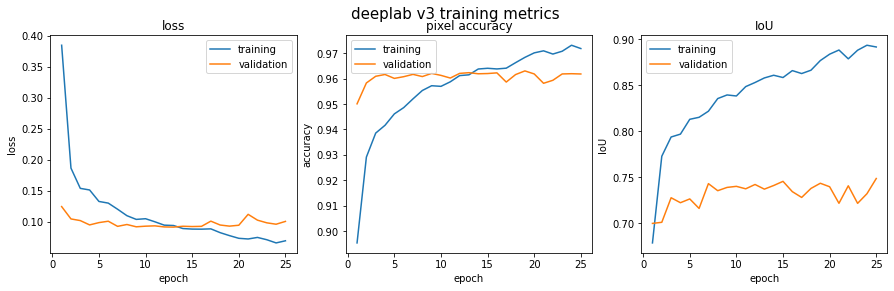

In [ ]:
epochs = 25
epochs_ = range(1,epochs+1)

# Displaying images and targets side by side
fig, axarr = plt.subplots(1, 3,figsize=(15,4))
fig.suptitle('deeplab v3 training metrics',fontsize=15)
axarr[0].plot(epochs_,train_losses,label='training')
axarr[0].plot(epochs_,val_losses,label='validation')
axarr[0].set_xlabel("epoch")
axarr[0].set_ylabel("loss")
axarr[0].legend()
axarr[0].set_title("loss")
axarr[1].plot(epochs_,train_accs,label='training')
axarr[1].plot(epochs_,val_accs,label='validation')
axarr[1].set_xlabel("epoch")
axarr[1].set_ylabel("accuracy")
axarr[1].legend()
axarr[1].set_title("pixel accuracy")
axarr[2].plot(epochs_,train_ious,label='training')
axarr[2].plot(epochs_,val_ious,label='validation')
axarr[2].set_xlabel("epoch")
axarr[2].set_ylabel("IoU")
axarr[2].legend()
axarr[2].set_title("IoU")


plt.show()

## Loop over entire dataset and compute GVI for every point

In [ ]:
N = len(slc_data)
D = 3
# cols for final csv
cols = ['GVI','latitude','longitude']
# gvi data 
gvi_data = np.empty(shape=(N,D))


for i in tqdm(range(N)):
  images, location = slc_data[i]
  GVI = []
  for idx,img in enumerate(images):
    img = img.unsqueeze(0).to(device)
    # make prediction
    best_model.eval()
    with torch.no_grad():
      outputs = best_model(img)
      output = outputs['out']
      preds = output.max(dim=1)[1].type(torch.LongTensor).squeeze()

      preds_cpu = preds.cpu().numpy()

      # overlay_predictions(img.squeeze(),preds.squeeze()) 

      # clear stuff from GPU
      # del img
      # del output
      # del outputs
      # del preds
      # torch.cuda.empty_cache()

      # Compute GVI
      GVI.append(green_view_index([preds_cpu]))

  # print(GVI)
  gvi_data[i,0] = np.mean(GVI)
  gvi_data[i,1] = location.lat
  gvi_data[i,2] = location.lon
  # print(gvi_data[i])

  if i == 4500:
    # Save data to csv around halfway point
    df = pd.DataFrame(gvi_data)
    path = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/gvi_data_half.csv'
    df.to_csv(path_or_buf=path, header=cols)


# Save data to csv
df = pd.DataFrame(gvi_data)
path = '/content/drive/My Drive/Colab Notebooks/Deep Learning 2020/project/gvi_data.csv'
df.to_csv(path_or_buf=path, header=cols)


## Scraps